# Modello gamma-esponenziale {#sec-gamma-exponential-model}

**Prerequisiti**

- Leggere il @sec-cont-rv-distr.

**Concetti e competenze chiave**

- Comprendere la distribuzione esponenziale come un modello probabilistico adatto per descrivere i tempi di attesa.
- Sapere applicare il metodo basato su griglia per derivare la distribuzione a posteriori del parametro λ del modello Gamma-Esponenziale.
- Conoscere il modello coniugato Gamma-Esponenziale, dimostrando come la distribuzione a priori Gamma si combini con la verosimiglianza esponenziale per produrre una distribuzione a posteriori Gamma.
- Sapere come calcolare e interpretare le probabilità utilizzando la distribuzione a posteriori.

**Preparazione del Notebook**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import arviz as az
import warnings

warnings.filterwarnings("ignore")

In [4]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "gamma-exponential-model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina"

## Introduzione 

Nell'inferenza bayesiana, il modello coniugato Gamma-Esponenziale rappresenta un approccio analitico efficace per l'analisi di dati che seguono una distribuzione esponenziale. Questa distribuzione è comunemente utilizzata per modellare i tempi di attesa tra eventi in processi di Poisson, come ad esempio gli intervalli tra arrivi in un sistema a coda o la durata di eventi psicologici.

Consideriamo, ad esempio, un esperimento in psicologia in cui si misurano i tempi di insorgenza di episodi di ansia in seguito a un evento stressante. In questo caso, si può ipotizzare che i tempi di insorgenza siano distribuiti esponenzialmente. Il parametro $\lambda$ della distribuzione esponenziale rappresenta il tasso medio con cui si verificano gli episodi di ansia. 

Il modello coniugato Gamma-Esponenziale consente di stimare il parametro $\lambda$ utilizzando i dati osservati. La distribuzione a priori Gamma viene utilizzata per rappresentare l'incertezza iniziale su $\lambda$, mentre la distribuzione esponenziale modella i dati osservati. Grazie a questa coniugazione, l'aggiornamento delle credenze sul parametro $\lambda$ avviene in modo semplice e analitico, permettendo di ottenere una stima bayesiana del tasso medio di occorrenza degli episodi di ansia, fornendo così una descrizione probabilistica accurata del fenomeno in esame.

### Il Modello Matematico

**Caso singolo.** Supponiamo di osservare un singolo tempo di attesa $y_1$ prima che si verifichi un evento, come un episodio di disagio psicologico. Assumiamo che questo tempo di attesa segua una distribuzione esponenziale con parametro $\lambda$. La funzione di densità di probabilità (pdf) della distribuzione esponenziale è data da:

$$
f(y_1 \mid \lambda) = \lambda e^{-\lambda y_1},
$$

dove:

- $y_1$ rappresenta il tempo di attesa,
- $\lambda$ è il parametro della distribuzione, che rappresenta il tasso medio con cui gli eventi si verificano per unità di tempo.

In questa distribuzione, $\lambda$ è il *tasso di occorrenza* o *tasso di decadimento*, ed è l'inverso del tempo medio di attesa. Più precisamente:

- Il *tempo medio di attesa* è il valore medio del tempo che trascorre prima che l'evento si verifichi (ad esempio, quanto tempo ci si aspetta in media prima che arrivi un autobus).
- Il parametro $\lambda$ rappresenta la frequenza con cui l'evento si verifica per unità di tempo, e quindi $\lambda = \frac{1}{\text{tempo medio}}$.

Pertanto, nella funzione esponenziale $f(y_1 \mid \lambda) = \lambda e^{-\lambda y_1}$, il parametro $\lambda$ è inversamente proporzionale al tempo medio di attesa: più grande è $\lambda$, più breve è il tempo medio di attesa tra gli eventi.

Questa funzione descrive la probabilità di osservare un tempo di attesa esattamente uguale a $y_1$, dato un valore specifico di $\lambda$. Per la distribuzione esponenziale, la media è $\frac{1}{\lambda}$ e la varianza è $\frac{1}{\lambda^2}$, il che riflette l'influenza del tasso $\lambda$ sulla dispersione dei tempi di attesa.

Per fare un esempio, supponiamo che il tempo medio di attesa sia 2 ore. In tali circostanze, il parametro $\lambda$ (l'inverso del tempo medio di attesa) è $\frac{1}{2}$.

In [5]:
# Parametro lambda (l'inverso del tempo medio di attesa)
lambda_value = 1 / 2

Disegniamo la funzione esponenziale per tempi di attesa compresi tra 0 e 10 ore.

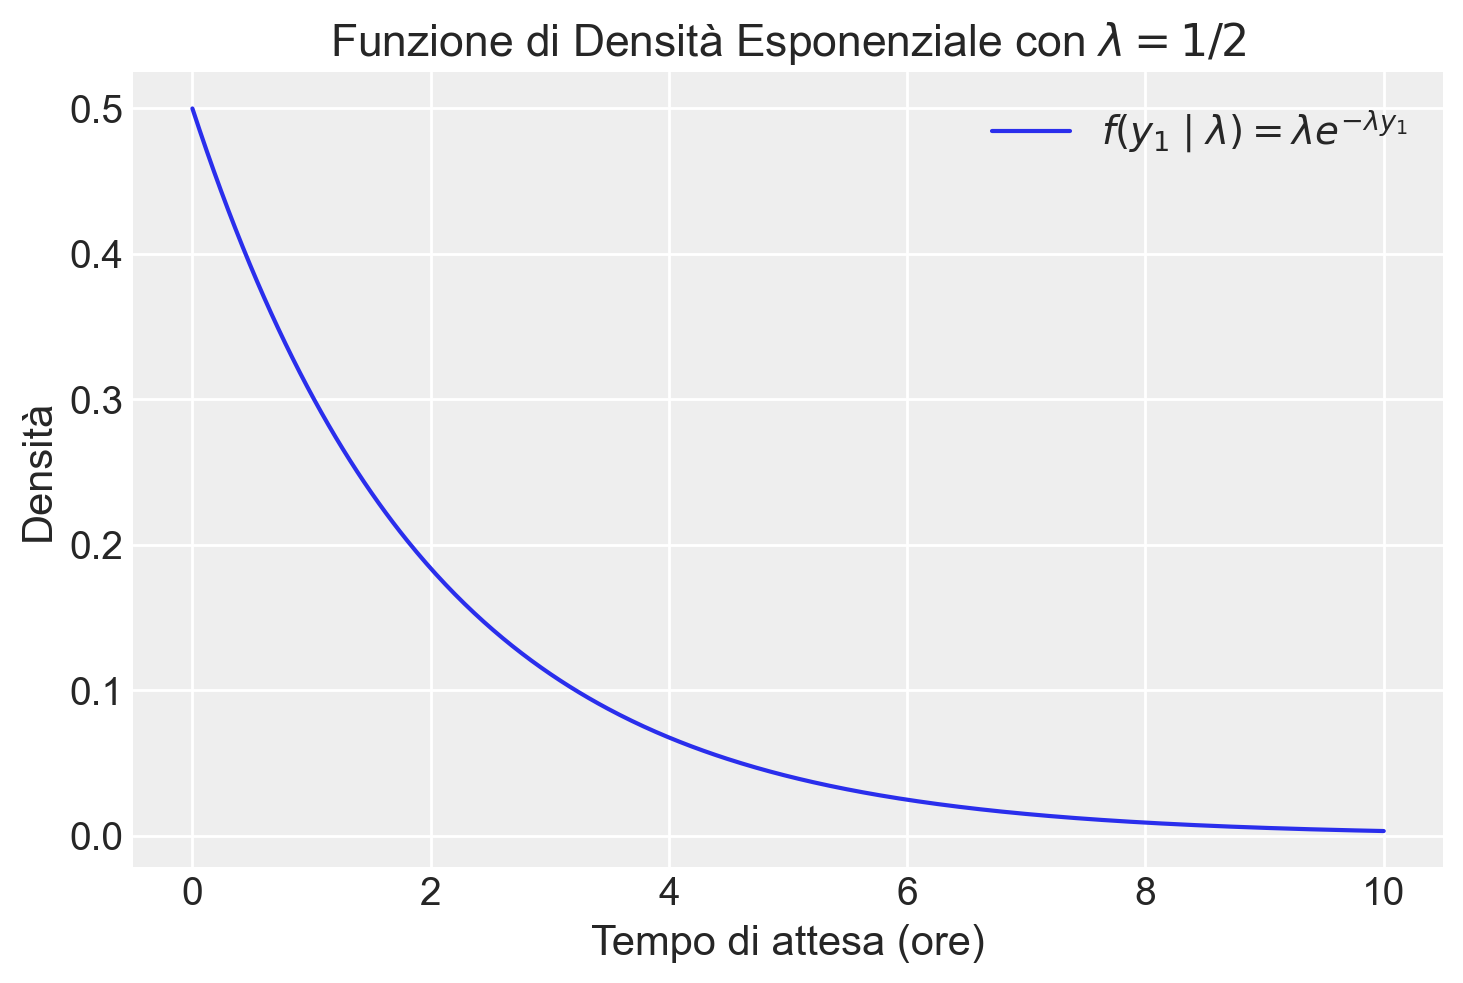

In [6]:
# Creazione dei valori di y1 su cui valutare la funzione
y1_values = np.linspace(0, 10, 500)  # Intervallo da 0 a 10 ore

# Definizione della funzione di densità esponenziale
def exponential_density(y1, lambda_value):
    return lambda_value * np.exp(-lambda_value * y1)

# Calcolo dei valori di f(y1 | lambda)
f_values = exponential_density(y1_values, lambda_value)

# Creazione del grafico
plt.plot(y1_values, f_values, label=r'$f(y_1 \mid \lambda) = \lambda e^{-\lambda y_1}$')
plt.title('Funzione di Densità Esponenziale con $\lambda = 1/2$')
plt.xlabel('Tempo di attesa (ore)')
plt.ylabel('Densità')
plt.legend()
plt.show()

**Il caso di $n$ osservazioni indipendenti.** Consideriamo ora un campione di $n$ osservazioni indipendenti $y_1, y_2, \dots, y_n$. L'indipendenza tra le osservazioni implica che il tempo di attesa osservato per un evento non influisce sulla probabilità di osservare altri tempi di attesa.

Poiché le osservazioni sono indipendenti, la probabilità congiunta di osservare tutti i tempi di attesa nel campione è il prodotto delle probabilità individuali. Di conseguenza, la funzione di verosimiglianza per l'intero campione è data da:

$$
f(y_1, y_2, \dots, y_n \mid \lambda) = f(y_1 \mid \lambda) \cdot f(y_2 \mid \lambda) \cdot \dots \cdot f(y_n \mid \lambda).
$$

Sostituendo la funzione di densità della distribuzione esponenziale per ciascuna osservazione, otteniamo:

$$
f(y \mid \lambda) = \lambda e^{-\lambda y_1} \cdot \lambda e^{-\lambda y_2} \cdot \dots \cdot \lambda e^{-\lambda y_n}.
$$

Raccogliendo i termini comuni, possiamo riscrivere la funzione di verosimiglianza come:

$$
f(y \mid \lambda) = \lambda^n e^{-\lambda (y_1 + y_2 + \dots + y_n)}.
$$

Utilizzando la notazione di sommatoria, possiamo esprimere la funzione di verosimiglianza in modo compatto come:

$$
f(y \mid \lambda) = \lambda^n e^{-\lambda \sum_{i=1}^{n} y_i}.
$$

La funzione di verosimiglianza $f(y \mid \lambda)$ rappresenta la probabilità di osservare il campione $y_1, y_2, \dots, y_n$ dato un particolare valore del parametro $\lambda$. Un valore più alto della verosimiglianza indica una maggiore plausibilità del valore di $\lambda$, dato il campione osservato.

Spesso è più conveniente lavorare con il logaritmo della funzione di verosimiglianza, poiché il logaritmo trasforma i prodotti in somme, semplificando i calcoli. Il logaritmo della funzione di verosimiglianza è:

$$
\log L(\lambda \mid y_1, y_2, \dots, y_n) = n \log \lambda - \lambda \sum_{i=1}^{n} y_i.
$$

Questa forma semplificata della log-verosimiglianza è utile per stimare il parametro $\lambda$ tramite tecniche come la massimizzazione della verosimiglianza.

## Aggiornare le Nostre Credenze con l'Inferenza Bayesiana

Nell'approccio bayesiano, non consideriamo solo i dati, ma anche le nostre conoscenze a priori sul parametro $\lambda$. Assegniamo a $\lambda$ una distribuzione a priori, tipicamente una distribuzione Gamma. Combinando la verosimiglianza con la distribuzione a priori, otteniamo la distribuzione a posteriori di $\lambda$, che rappresenta la nostra conoscenza aggiornata alla luce dei dati. La proprietà della coniugazione assicura che la distribuzione a posteriori sia anch'essa una Gamma, facilitando i calcoli.


Per fare un esempio concreto, simuleremo un campione di dati. Immaginiamo di raccogliere dati che rappresentano il tempo, misurato in ore, che intercorre tra episodi di ansia in individui con disturbi d'ansia. La distribuzione esponenziale può essere utilizzata per modellare questo tempo di attesa tra un episodio di ansia e il successivo. Ad esempio, possiamo ipotizzare che, una volta concluso un episodio, l'insorgenza del prossimo segua un processo stocastico con un tasso costante, indipendentemente dal tempo trascorso dall'episodio precedente. In questo contesto, il parametro $\lambda$ della distribuzione esponenziale rappresenta il tasso medio di occorrenza degli episodi di ansia, ossia quanti episodi ci si aspetta in media in una certa unità di tempo (ad esempio, in un giorno). 

In pratica, se $\lambda$ è elevato, ciò indica che gli episodi di ansia sono più frequenti, con tempi di attesa più brevi tra un episodio e l'altro.

In [9]:
# Imposta il seed per rendere i risultati riproducibili
np.random.seed(42)

# Parametro lambda per la distribuzione esponenziale
mean = 3.0
lambda_param = 1 / mean

# Numero di osservazioni nel campione
n = 15

# Generazione del campione casuale

y = np.random.exponential(scale=mean, size=n).round()
print(y)

[ 1.  9.  4.  3.  1.  1.  0.  6.  3.  4.  0. 11.  5.  1.  1.]
[ 1.  9.  4.  3.  1.  1.  0.  6.  3.  4.  0. 11.  5.  1.  1.]


Immaginiamo che questi dati corrispondano al tempo di attesa in ore tra episodi di ansia in 14 individui con disturbi d'ansia. Il tempo di attesa medio è

In [11]:
np.mean(y)

3.3333333333333335

e quindi il tasso di occorrenza, $\lambda$, è 

In [12]:
1 / np.mean(y)

0.3

Poniamoci il problema di trovare la distribuzione a posteriori per il tasso di occorrenza $\lambda$.

### Passi per definire un prior debolmente informativo

Il primo passo consiste nel definire una distribuzione a priori per $\lambda$, il tasso di occorrenza degli episodi di ansia in individui con disturbi d'ansia. Se disponiamo di poche informazioni a priori riguardo al valore di $\lambda$, possiamo adottare una distribuzione a priori **debolmente informativa**. Un prior debolmente informativo ha lo scopo di esercitare una minima influenza sull'inferenza, consentendo ai dati osservati di guidare principalmente la stima del parametro.

La distribuzione a priori **coniugata** per la distribuzione esponenziale è la distribuzione Gamma. Un prior debolmente informativo per $\lambda$ potrebbe essere impostato in modo tale da riflettere una conoscenza vaga, con una media che rappresenta un tempo di attesa ragionevole (basato su qualche informazione preliminare o ipotesi generale), ma con una varianza ampia, in modo da non vincolare eccessivamente l'inferenza.

Supponiamo, ad esempio, di voler impostare il prior con una media pari a 3.33 ore e una deviazione standard ampia, come 5. Tuttavia, vogliamo una distribuzione a priori per λ, che rappresenta il tasso di occorrenza (cioè l'inverso del tempo medio di attesa). Dobbiamo dunque applicare la distribuzione Gamma ai valori di λ, non direttamente ai tempi di attesa. In tali circostanze, i parametri $\alpha$ (forma) e $\theta$ (scala) sono dati da:

- $\alpha_{\text{prior}} = 0.45$,
- $\beta_{\text{prior}} = 1.5$.

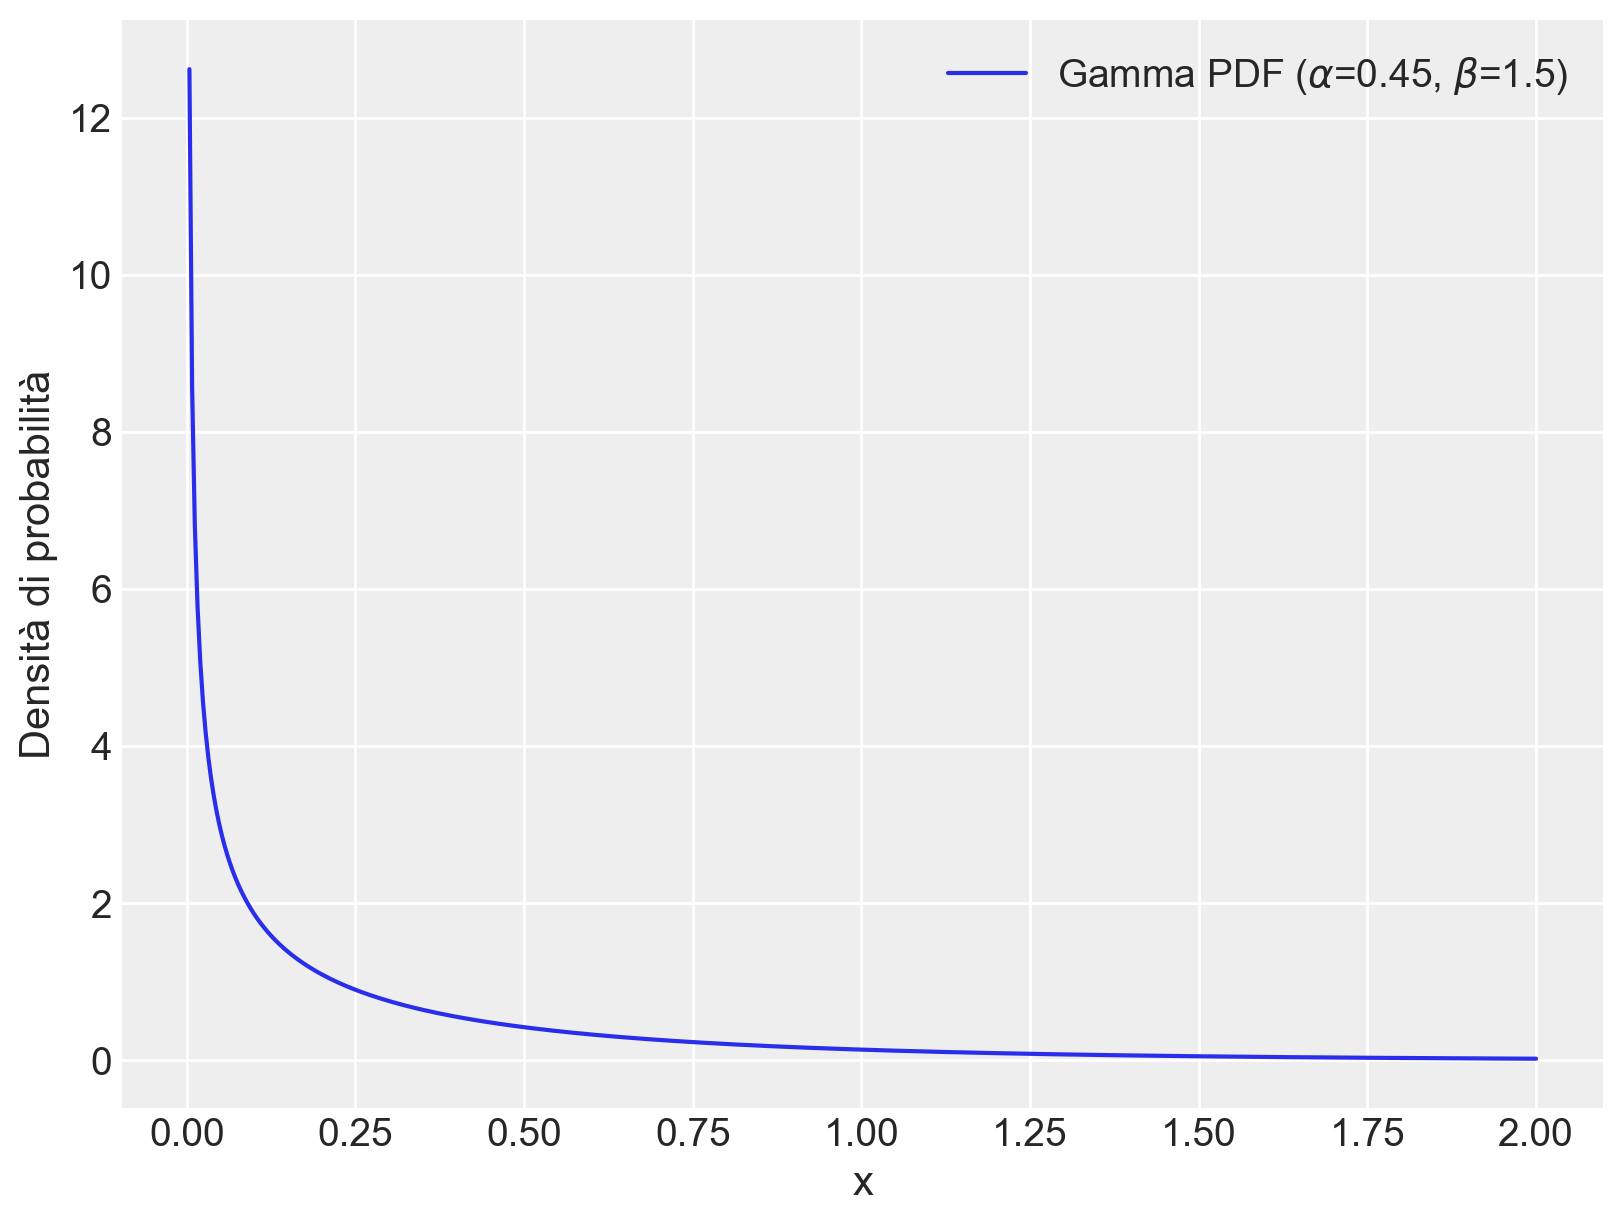

In [24]:
# Parametri della distribuzione Gamma
alpha_prior = 0.45  # Forma
beta_prior = 1.5   # Tasso (inverso della scala)

# Creazione dei valori x per il grafico
x = np.linspace(0, 2, 500)

# Funzione di densità della distribuzione Gamma con i parametri dati
gamma_pdf = stats.gamma.pdf(x, a=alpha_prior, scale=1/beta_prior)

# Creazione del grafico
plt.figure(figsize=(8, 6))
plt.plot(x, gamma_pdf, label=f'Gamma PDF ($\\alpha$={alpha}, $\\beta$={beta})')
plt.xlabel('x')
plt.ylabel('Densità di probabilità')
plt.legend()
plt.show()

Verifichiamo:

In [22]:
# Calcoliamo la media e la varianza della distribuzione Gamma per il tasso di occorrenza (lambda)
mean_lambda = alpha / beta
variance_lambda = alpha / (beta**2)

# Ora trasformiamo questi valori per ottenere la media e la varianza dei tempi di attesa, non del tasso
mean_waiting_time = 1 / mean_lambda
variance_waiting_time = variance_lambda / (mean_lambda**4)  # Trasformazione della varianza per il tempo di attesa

mean_waiting_time, variance_waiting_time

(3.3333333333333335, 24.69135802469136)

La media e la varianza della distribuzione Gamma per il tasso di occorrenza (λ) sono state calcolate come segue:

- La media del tempo di attesa (trasformata dalla media del tasso) è 3.33 ore. 
- La varianza del tempo di attesa è 24.59 ore. 

Questi valori riflettono il tempo di attesa medio e la variabilità nei tempi di attesa degli episodi di ansia, non più il reciproco del tempo.

## Metodo Basato su Griglia

Poniamoci l'obiettivo di usare il metodo basato su griglia per derivare la distribuzione a posteriori per il parametro $\lambda$ della distribuzione esponenziale. Iniziamo con la creazione della griglia per $\lambda$ nell'intervallo [0.01, 10].

In [31]:
# Evita zero per evitare divisione per zero
lambda_grid = np.linspace(0.01, 2, 1000)

Calcoliamo la distribuzione a priori.

In [32]:
prior = stats.gamma.pdf(lambda_grid, a=alpha_prior, scale=1 / beta_prior)

Calcoliamo la verosimiglianza per ciascun valore di lambda.

In [33]:
likelihood = np.ones_like(lambda_grid)
for yi in y:
    likelihood *= stats.expon.pdf(yi, scale=1 / lambda_grid)

Calcoliamo la distribuzione a posteriori non normalizzata.

In [34]:
posterior_unnormalized = likelihood * prior

Normalizziamo la distribuzione a posteriori.

In [35]:
posterior = posterior_unnormalized / np.sum(
    posterior_unnormalized * (lambda_grid[1] - lambda_grid[0])
)

Visualizzazione dei risultati.

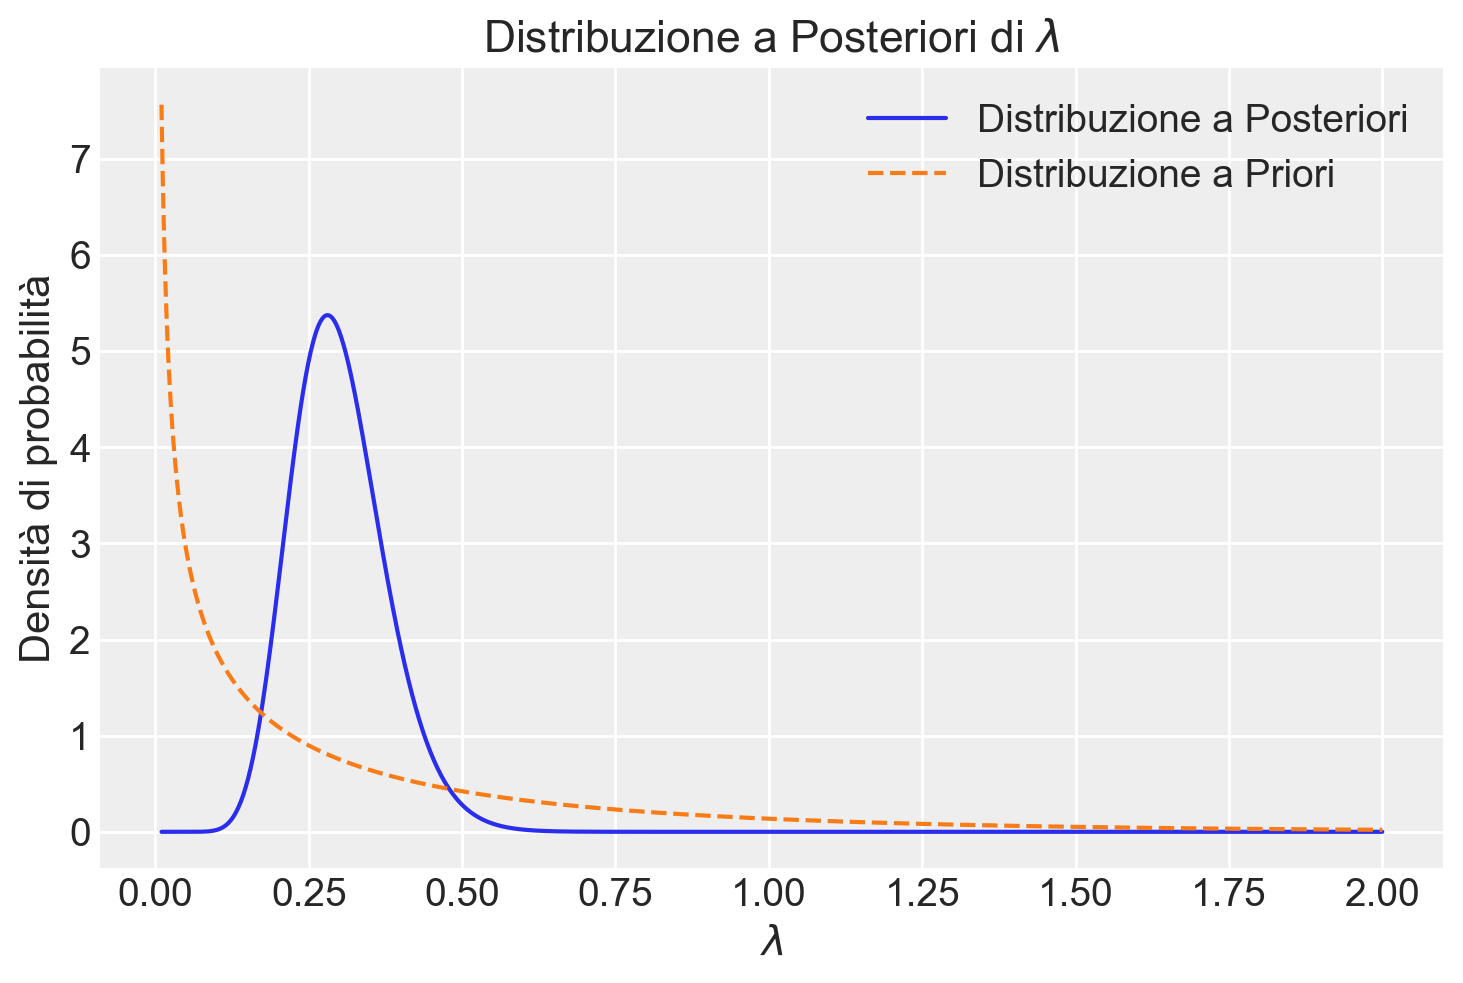

In [36]:
plt.plot(lambda_grid, posterior, label="Distribuzione a Posteriori")
plt.plot(lambda_grid, prior, "--", label="Distribuzione a Priori")
plt.xlabel(r"$\lambda$")
plt.ylabel("Densità di probabilità")
plt.legend()
plt.title("Distribuzione a Posteriori di $\lambda$")
plt.show()

## Modello Coniugato Gamma-Esponenziale

Quando utilizziamo una distribuzione $\text{Gamma}(\alpha, \beta)$ come [distribuzione coniugata a priori](https://en.wikipedia.org/wiki/Conjugate_prior), la distribuzione a posteriori risulta anch'essa essere una distribuzione Gamma, con parametri aggiornati $\alpha + n$ e $\beta + \sum_{i=1}^{n} x_{i}$.

In altre parole, se il parametro $\lambda$ della distribuzione esponenziale segue una distribuzione a priori Gamma con parametri $\alpha$ e $\beta$, allora, dopo aver osservato un campione di $n$ osservazioni $x_1, x_2, \dots, x_n$, la distribuzione a posteriori di $\lambda$ sarà ancora una distribuzione Gamma, ma con i parametri aggiornati:

$$
\lambda \mid x \sim \text{Gamma}(\alpha + n, \beta + \sum_{i=1}^{n} x_{i}).
$$

Questo aggiornamento dei parametri è una conseguenza della proprietà coniugata della distribuzione Gamma rispetto alla distribuzione esponenziale.

### Dimostrazione del Modello Coniugato Gamma-Esponenziale

Per dimostrare questo risultato, partiamo dal teorema di Bayes:

$$
f(\lambda \mid x) \propto f(x \mid \lambda) \cdot f(\lambda),
$$

dove $f(\lambda \mid x)$ è la distribuzione a posteriori di $\lambda$ dato il campione $x$, $f(x \mid \lambda)$ è la verosimiglianza basata sul campione $x$, e $f(\lambda)$ è la distribuzione a priori di $\lambda$.

La funzione di verosimiglianza per un campione di $n$ osservazioni indipendenti $x_1, x_2, \dots, x_n$, che seguono una distribuzione esponenziale con parametro $\lambda$, è data da:

$$
f(x \mid \lambda) = \prod_{i=1}^{n} \lambda e^{-\lambda x_i} = \lambda^n e^{-\lambda \sum_{i=1}^{n} x_i}.
$$

Supponiamo che il parametro $\lambda$ segua una distribuzione a priori Gamma con parametri $\alpha$ e $\beta$:

$$
f(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}.
$$

Moltiplicando la verosimiglianza per la distribuzione a priori, otteniamo la distribuzione a posteriori:

$$
f(\lambda \mid x) \propto \lambda^n e^{-\lambda \sum_{i=1}^{n} x_i} \cdot \lambda^{\alpha - 1} e^{-\beta \lambda}.
$$

Semplificando, si ottiene:

$$
f(\lambda \mid x) \propto \lambda^{n + \alpha - 1} e^{-\lambda \left(\beta + \sum_{i=1}^{n} x_i\right)}.
$$

Questa espressione corrisponde alla forma di una distribuzione Gamma con parametri aggiornati:

- parametro della forma (alpha): $\alpha_{\text{post}} = \alpha + n$;
- parametro della scala (beta): $\beta_{\text{post}} = \beta + \sum_{i=1}^{n} x_i$.


Quindi, la distribuzione a posteriori di $\lambda$ dato il campione $x$ segue una distribuzione Gamma con parametri aggiornati:

$$
\lambda \mid x \sim \text{Gamma}(\alpha + n, \beta + \sum_{i=1}^{n} x_i).
$$

Questa derivazione mostra come l'informazione contenuta nei dati osservati venga incorporata nei parametri della distribuzione a posteriori, mantenendo la forma della distribuzione a priori grazie alla proprietà coniugata.

Per il caso dell'esempio in discussione, 

- il numero di osservazioni nel campione $n$ è 15;
- la somma delle osservazioni del campione è:

$$
\sum_{i=1}^{n} y_i = 1 + 9 + 4 + 3 + 1 + 1 + 0 + 6 + 3 + 4 + 0 + 11 + 5 + 1 + 1 = 50
$$

I parametri aggiornati della distribuzione a posteriori sono:

$$
\alpha_{\text{post}} = 15 + 0.009 = 15.009.
$$

$$
\beta_{\text{post}} = 50 + 0.03 = 50.03.
$$

Utilizzando i parametri aggiornati, rappresentiamo graficamente la distribuzione a posteriori.

In [37]:
# Aggiornamento dei parametri per la distribuzione a posteriori
alpha_post = alpha_prior + len(y)
beta_post = beta_prior + np.sum(y)

print(f"alpha_post = {alpha_post}; beta_post = {beta_post:.4f}")

alpha_post = 15.45; beta_post = 51.5000
alpha_post = 15.45; beta_post = 51.5000


Quindi, la distribuzione a posteriori di $\lambda$ è:

$$
p(\lambda \mid y) \sim \text{Gamma}(15.009, 50.03).
$$

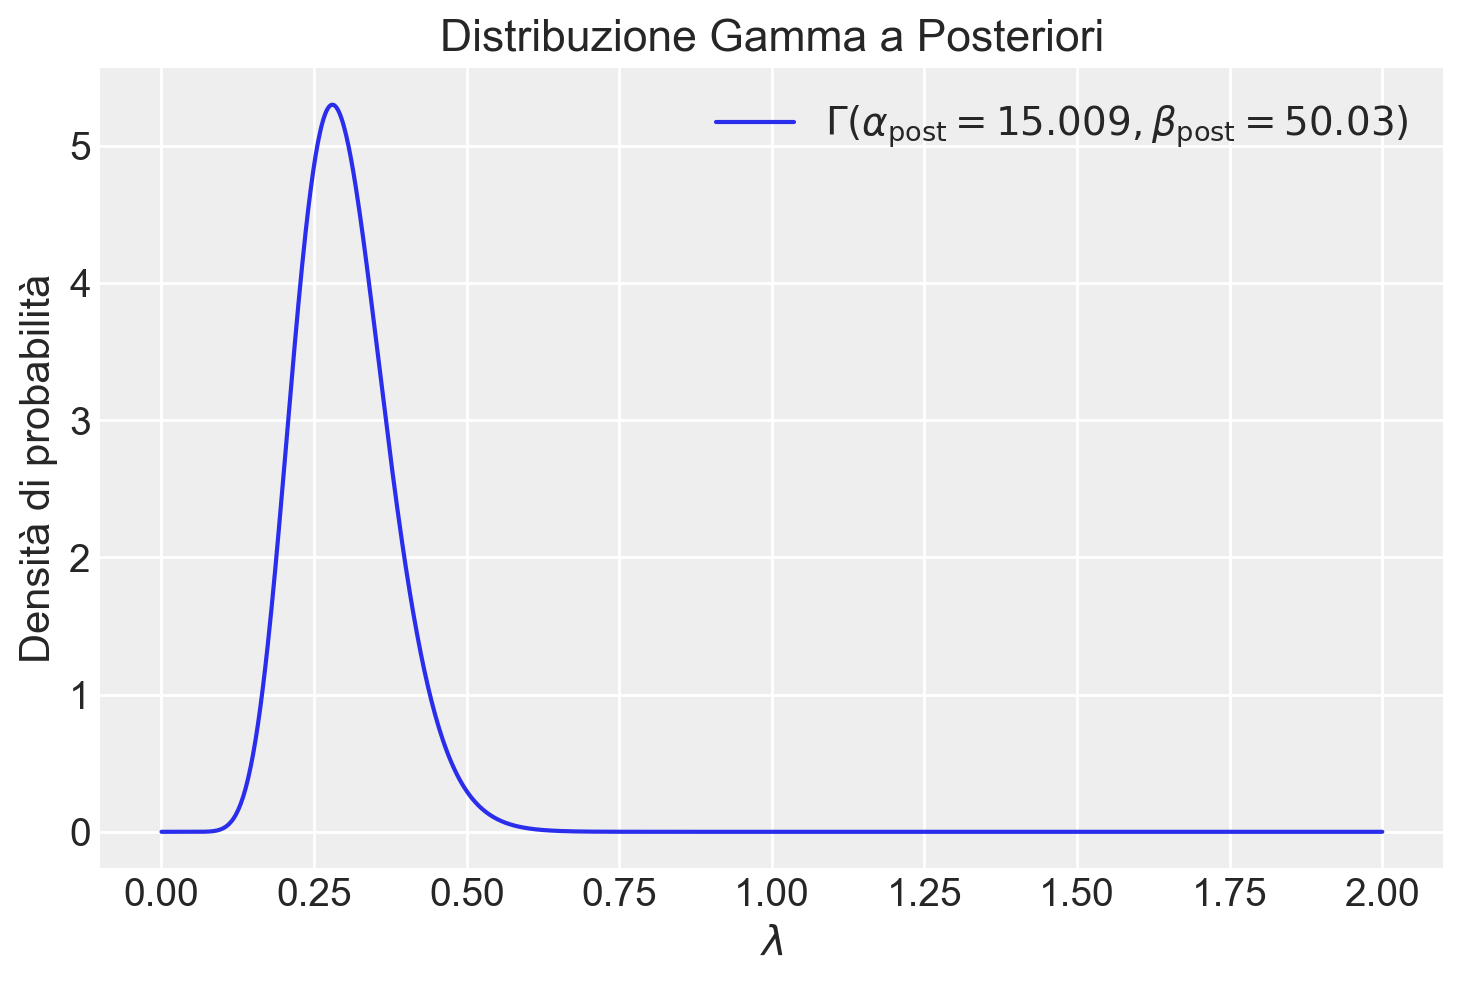

In [40]:
# Parametri della distribuzione Gamma a posteriori
alpha_post = 15.009
beta_post = 50.03

# Griglia di valori di lambda per il plot
lambda_grid = np.linspace(0, 2, 1000)

# Calcolo della distribuzione Gamma a posteriori
posterior_pdf = stats.gamma.pdf(lambda_grid, a=alpha_post, scale=1 / beta_post)

# Plot della distribuzione a posteriori
plt.plot(
    lambda_grid,
    posterior_pdf,
    label=r"$\Gamma(\alpha_{\text{post}}=15.009, \beta_{\text{post}} = 50.03)$",
)
plt.xlabel(r"$\lambda$")
plt.ylabel("Densità di probabilità")
plt.title("Distribuzione Gamma a Posteriori")
plt.legend()
plt.show()

Questa distribuzione Gamma a posteriori riflette l'informazione combinata proveniente sia dal prior che dai dati osservati. Con i parametri $\alpha_{\text{posteriori}} = 15.009$ e $\beta_{\text{posteriori}} = 50.03$, la distribuzione a posteriori di $\lambda$ (il tasso di occorrenza degli episodi di ansia) sarà centrata attorno alla media:

$$
\text{E}[\lambda \mid y] = \frac{\alpha_{\text{posteriori}}}{\beta_{\text{posteriori}}} \approx \frac{15.009}{50.03} \approx 0.3,
$$

con una varianza:

$$
\text{Var}[\lambda \mid y] = \frac{\alpha_{\text{posteriori}}}{\beta_{\text{posteriori}}^2} \approx \frac{15.009}{50.03^2} \approx 0.006.
$$

Questi valori si riferiscono alla distribuzione del tasso di occorrenza $\lambda$, che rappresenta il reciproco del tempo medio di attesa tra episodi di ansia. 

### Trasformazione della media e della varianza

Per interpretare questi risultati in termini di *tempi di attesa*, dobbiamo trasformare i valori sulla scala inversa, cioè passare dal tasso $\lambda$ ai tempi di attesa $T = \frac{1}{\lambda}$.

La *media* del tempo di attesa $T$ è l'inverso della media del tasso di occorrenza $\lambda$. Pertanto, la media dei tempi di attesa sarà:

$$
\text{E}[T \mid y] = \frac{1}{\text{E}[\lambda \mid y]} = \frac{1}{0.3} \approx 3.33 \, \text{ore}.
$$

Per la *varianza* del tempo di attesa, dobbiamo applicare una trasformazione più complessa. La varianza del tempo di attesa $T$ è legata alla varianza di $\lambda$ da:

$$
\text{Var}(T) = \frac{\text{Var}[\lambda \mid y]}{(\text{E}[\lambda \mid y])^4}.
$$

Sostituendo i valori calcolati per la varianza e la media di $\lambda$, otteniamo:

$$
\text{Var}(T) \approx \frac{0.006}{(0.3)^4} \approx 24.59 \, \text{ore}.
$$

In conclusione, 

- la *media* del tempo di attesa a posteriori è di circa 3.33 ore;
- la *varianza* del tempo di attesa a posteriori è di circa 24.59 ore, che indica una certa dispersione dei tempi di attesa, con alcuni episodi che possono verificarsi molto più rapidamente o più lentamente rispetto alla media. Si noti che la distribuzione a posteriori è più concentrata rispetto al prior, poiché incorpora l’informazione aggiuntiva proveniente dai dati osservati.

Questa trasformazione ci permette di interpretare i risultati sulla scala dei tempi di attesa, che è più intuitiva per descrivere fenomeni psicologici come l'insorgenza di episodi di ansia.

## Applicazioni

Una volta ottenuta la distribuzione a posteriori per λ, possiamo utilizzarla per rispondere a domande probabilistiche relative ai tempi di attesa tra episodi di ansia. Questo approccio ci consente di calcolare probabilità aggiornate alla luce dei dati osservati, rispecchiando meglio l'incertezza e le informazioni disponibili. Ad esempio, possiamo stimare la probabilità di osservare tempi di attesa compresi tra 2 e 5 ore.

Per risolvere questo problema possiamo usare il metodo Monte Carlo:

1. Generiamo un gran numero di campioni dalla distribuzione Gamma a posteriori di $\lambda$, usando i parametri $\alpha_{\text{posteriori}}$ e $\beta_{\text{posteriori}}$.
2. Convertiamo ciascun $\lambda$ campionato in un tempo di attesa $T = \frac{1}{\lambda}$.
3. Calcoliamo le probabilità richieste (ad esempio, $P(T > 2)$ e $P(T < 5)$) semplicemente contando le proporzioni di campioni che soddisfano tali condizioni.

Procediamo con l'implementazione in Python.

In [45]:
# Parametri posteriori per la distribuzione Gamma
alpha_post = 15.009
beta_post = 50.03

# Numero di campioni da generare
n_samples = 100000

# Simuliamo i campioni dalla distribuzione a posteriori di lambda (Gamma)
lambda_samples = np.random.gamma(alpha_post, 1/beta_post, n_samples)

# Convertiamo i campioni di lambda nei tempi di attesa T = 1/lambda
waiting_time_samples = 1 / lambda_samples

# Calcoliamo la probabilità che il tempo di attesa sia compreso tra 2 e 5 ore
prob_between_2_and_5_mc = np.mean((waiting_time_samples >= 2) & (waiting_time_samples <= 5))

prob_between_2_and_5_mc

0.90603

La probabilità che il tempo di attesa tra due episodi di ansia sia compreso tra 2 e 5 ore è di circa 0.9029, ovvero circa il 90.3%.

## Riflessioni Conclusive

Il modello esponenziale si rivela uno strumento utile e versatile nella ricerca psicologica, in particolare per la modellazione di fenomeni caratterizzati da tempi di attesa o durate di eventi. È applicabile in vari contesti, tra cui l'analisi dei tempi di reazione, lo studio degli intervalli tra episodi di ansia o depressione e, più in generale, in tutti quei processi psicologici che possono essere descritti come il tempo trascorso fino al verificarsi di un evento.

Un aspetto particolarmente vantaggioso dell'uso di modelli basati sulla distribuzione esponenziale nell'inferenza bayesiana è la possibilità di utilizzare le famiglie coniugate. Nella famiglia coniugata Gamma-Esponenziale, la distribuzione a priori Gamma per il tasso $\lambda$ si aggiorna in modo analitico quando si osservano nuovi dati esponenziali. Questo rende i calcoli bayesiani particolarmente efficienti e semplici da implementare, poiché la distribuzione a posteriori rimane della stessa forma della distribuzione a priori (ossia, una Gamma). Tale proprietà coniugata consente di ottenere una stima aggiornata del tasso $\lambda$ e di fare inferenze accurate sui tempi di attesa futuri.

La combinazione tra la distribuzione esponenziale e il prior Gamma non solo semplifica l'inferenza, ma fornisce anche una struttura interpretativa chiara. Ad esempio, il parametro $\lambda$, che rappresenta il tasso di occorrenza di un fenomeno, viene aggiornato sulla base dell'evidenza osservata, consentendo una stima dinamica della frequenza con cui gli episodi si verificano. Questo approccio bayesiano offre un'interpretazione probabilistica naturale dei tempi di attesa futuri, rispecchiando l'incertezza presente nei dati.

Inoltre, grazie alla flessibilità del metodo Monte Carlo, è possibile simulare campioni dalla distribuzione a posteriori di $\lambda$ e ottenere stime precise per una vasta gamma di probabilità, come la probabilità che il tempo di attesa sia compreso tra intervalli specifici. Questo approccio simulativo permette di rispondere a domande specifiche relative ai processi psicologici, ad esempio la probabilità che un episodio di ansia duri più di un certo numero di ore.

In conclusione, il modello esponenziale, integrato in un framework bayesiano con famiglie coniugate, rappresenta un utile strumento per la ricerca psicologica. Offre un modo rigoroso per modellare e analizzare dati su tempi di attesa e durate, fornendo al contempo una base solida per l'inferenza e la previsione dei processi psicologici.

## Informazioni sull'Ambiente di Sviluppo

In [46]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Wed Sep 11 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
pandas    : 2.2.2
seaborn   : 0.13.2
matplotlib: 3.9.1
scipy     : 1.14.0
arviz     : 0.18.0

Watermark: 2.4.3

Last updated: Wed Sep 11 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
pandas    : 2.2.2
seaborn   : 0.13.2
matplotlib: 3.9.1
scipy     : 1.14.0
arviz     : 0.18.0

Watermark: 2.4.3

